In [1]:
import torch
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.datasets import load_diabetes, load_breast_cancer
from sklearn.linear_model import LinearRegression
from torch import nn

In [2]:
data = pd.read_csv("data/insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [3]:
data["sex"] = (data["sex"]=="male").astype(np.int64)
data["smoker"] = (data["smoker"]=="yes").astype(np.int64)

data["region_1"] = (data["region"]=="southwest").astype(np.int64)
data["region_2"] = (data["region"]=="southeast").astype(np.int64)
del data["region"]

data.head()

,age,sex,bmi,children,smoker,expenses,region_1,region_2
0,19,0,27.9,0,1,16884.92,1,0
1,18,1,33.8,1,0,1725.55,0,1
2,28,1,33.0,3,0,4449.46,0,1
3,33,1,22.7,0,0,21984.47,0,0
4,32,1,28.9,0,0,3866.86,0,0


In [4]:
X,y = data.drop(columns="expenses").values, data["expenses"].values

<AxesSubplot: ylabel='Count'>

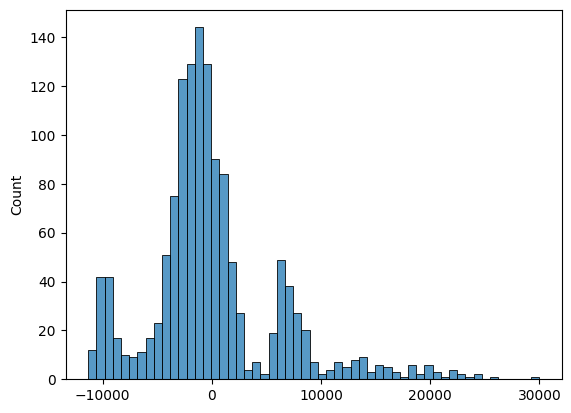

In [5]:
sns.histplot(y-LinearRegression().fit(X,y).predict(X))

In [6]:
train_idx = np.arange(0,X.shape[0] * 60 // 100)
val_idx = np.arange(X.shape[0] * 60 // 100, X.shape[0] * 80 // 100)
test_idx = np.arange(X.shape[0] * 80 // 100, X.shape[0])

In [7]:
x_train, y_train = X[train_idx], y[train_idx]
x_val, y_val = X[val_idx], y[val_idx]
x_test, y_test = X[test_idx], y[test_idx]

In [8]:
class net(nn.Module):
    def __init__(self,input_size,output_size):
        super(net,self).__init__()
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(input_size,20)
        self.l2 = nn.Linear(20,20)
        self.l3 = nn.Linear(20,output_size)
    def forward(self,x):
        output = self.l1(x) 
        output = self.relu(output)
        output = self.l2(output)
        output = self.relu(output)
        output = self.l3(output)
        return output

In [10]:
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)

In [11]:
x_val = torch.Tensor(x_val)
y_val = torch.Tensor(y_val)

In [12]:
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)

In [13]:
y_train.mean(), y_train.var()

(tensor(13167.1162), tensor(1.4368e+08))

### Train a simple fitting model

In [ ]:
model = net(X.shape[1],1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
epochs = 150000

In [15]:
costval = []
min_val_loss = torch.inf
min_val_loss_idx = -1
best_model = model.state_dict()

EARLY_STOPPING_EPOCHS = 10000

for j in range(epochs):
    #prediction
    y_train_pred = model(x_train)
    
    #calculating loss
    cost = criterion(y_train_pred,y_train.reshape(-1,1))
  
    #backprop
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    val_loss = criterion(model(x_val), y_val.reshape(-1,1)).item()
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        min_val_loss_idx = j
        best_model = model.state_dict()
    elif j >= min_val_loss_idx + EARLY_STOPPING_EPOCHS:
        print(f"Early stopping at iteration {j} with val_loss {min_val_loss}")
        model.load_state_dict(best_model)
        break
    
    if j%10000 == 0:
        print(cost.item(), val_loss)
        costval.append(cost)

14526290.0 27934868.0
14091412.0 28958996.0
13689887.0 29139440.0
Early stopping at iteration 24778 with val_loss 26467750.0


### Train a CGAN

In [ ]:
generator = net(X.shape[1]+1,1)
discriminator = net(X.shape[1]+1,1)
criterion = nn.BCELoss()
optimizer_gen = torch.optim.Adam(generator.parameters(),lr=0.01)
optimizer_disc = torch.optim.Adam(discriminator.parameters(),lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
epochs = 150000
EARLY_STOPPING_EPOCHS = 10000


In [19]:
torch.concat((x_train, torch.randn(x_train.shape[0]).reshape(-1,1)), 1).shape

torch.Size([802, 8])

In [ ]:
costval = []
min_val_loss = torch.inf
min_val_loss_idx = -1
best_model = model.state_dict()

for j in range(epochs):
    #prediction
    x_train_gen = torch.concat(
        (
            x_train
            , torch.randn(x_train.shape[0]).reshape(-1,1))
        , 1
    )
    y_trains = torch.concat(
        (
            generator(x_train_gen).reshape(-1,1)
            ,y_train.reshape(-1,1)
        )
        , 1
    )

    ground_truths = (torch.rand((x_train.shape[0],1)) > 0.5).int32()
    x_train_disc = torch.concat(
        (
            x_train
            , y_trains[ground_truths]
        )
        , 1
    )

    disc_preds = discriminator(x_train_disc)
    
    #calculating loss
    cost = criterion(y_train_pred,y_train.reshape(-1,1))
  
    #backprop
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    val_loss = criterion(model(x_val), y_val.reshape(-1,1)).item()
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        min_val_loss_idx = j
        best_model = model.state_dict()
    elif j >= min_val_loss_idx + EARLY_STOPPING_EPOCHS:
        print(f"Early stopping at iteration {j} with val_loss {min_val_loss}")
        model.load_state_dict(best_model)
        break
    
    if j%10000 == 0:
        print(cost.item(), val_loss)
        costval.append(cost)

14526290.0 27934868.0
14091412.0 28958996.0
13689887.0 29139440.0
Early stopping at iteration 24778 with val_loss 26467750.0
